<a href="https://colab.research.google.com/github/yanglinjing/vmor/blob/master/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection

# Data
[Kaggle: IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection)

In [2]:
# All the documents are stored on Google Drive.
# It requires authorisation before use them.
# This chunk of code is about authorisation.

# Mounting Google Drive locally
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pwd

/content


In [4]:
#google colab - change path to google drive

import os 
os.chdir('gdrive/My Drive/Colab Notebooks/vmor_practicum/credit_card_fraud')
!pwd

/content/gdrive/My Drive/Colab Notebooks/vmor_practicum/credit_card_fraud


In [5]:
!ls

credit_card_fraud_detection.ipynb  data


In [6]:
# Import libraries

import numpy as np
import pandas as pd

# Imbalanced Data
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Learning Models
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Evaluate 
from sklearn.metrics import f1_score

# Plot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Pretty display for notebooks
% matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
my_color = ['#42bff4', '#f9ace9']

# Load Data

In [18]:
# Load datasets
train_transaction = pd.read_csv("data/train_transaction.csv")
train_identity = pd.read_csv('data/train_identity.csv')
test_transaction = pd.read_csv('data/test_transaction.csv')
test_identity = pd.read_csv('data/test_identity.csv')

In [19]:
# Outer Join transation and identity by 'TransactionID'

# train
train_transaction.set_index('TransactionID', inplace = True)
train_identity.set_index('TransactionID', inplace = True)
train = pd.concat([train_transaction,train_identity], axis=1, sort=False) #outer join
# shape (590540, 433)

# test
test_transaction.set_index('TransactionID', inplace = True)
test_identity.set_index('TransactionID', inplace = True)
test = pd.concat([test_transaction,test_identity], axis=1, sort=False) #outer join
# shape (506691, 432)

In [20]:
df = train.copy()

# Preprocessing Data

## Missing Values

### Missing Values in Columns

In [22]:
# Calculate the percentage of missing values of each column
missing = df.isnull().sum()
missing = missing[missing > 0] / df.shape[0] *100
missing.sort_values(inplace = True)

In [23]:
missing

V316      0.002032
V294      0.002032
V295      0.002032
V297      0.002032
V298      0.002032
           ...    
id_21    99.126393
id_08    99.127070
id_07    99.127070
id_25    99.130965
id_24    99.196159
Length: 414, dtype: float64

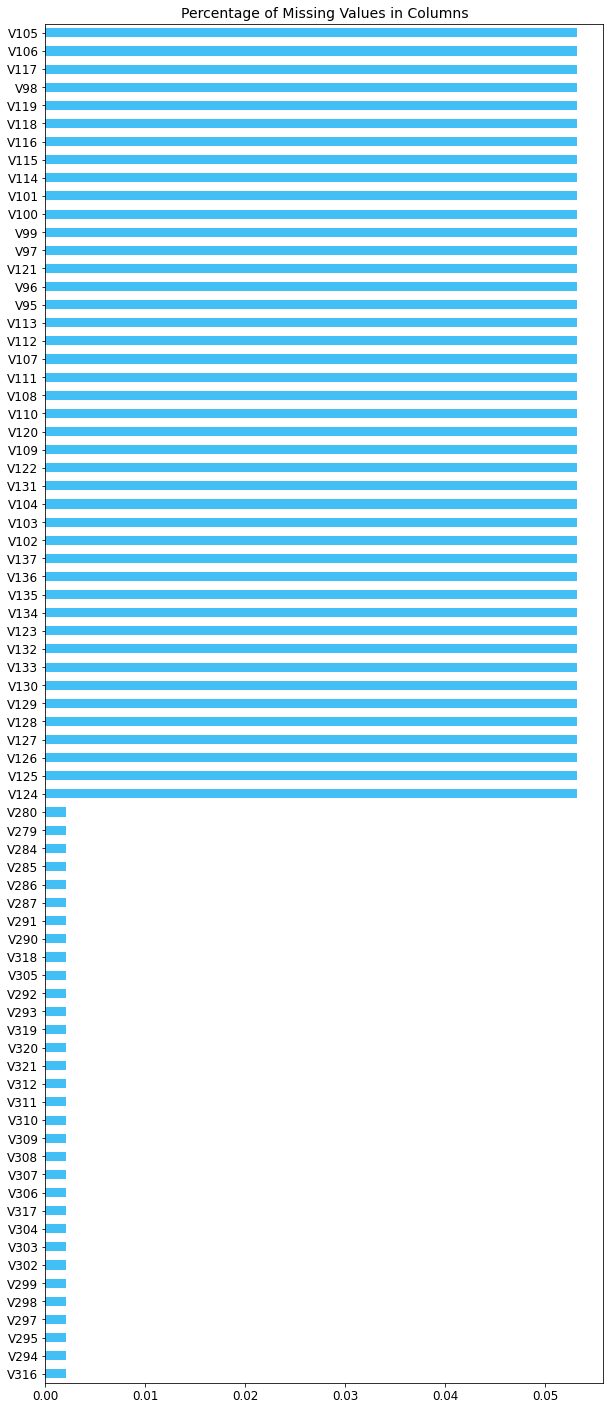

In [24]:
#Visualizing the naturally missing data
missing[missing < 0.1].plot.barh(figsize = (10, 25), fontsize = 12, color= my_color[0])
plt.title('Percentage of Missing Values in Columns', size = 14)
plt.show()

In [25]:
# columns have too much missing values
p = 0.01
missing_more = missing[missing > p]

print(f"{len(missing)} out of {train.shape[1]} columns contain missing values, from {round(missing[0], 2)}% to {round(missing[-1], 2)}%.")
print(f'{len(missing_more)} columns have more than {p*100}% missing values.')

414 out of 433 columns contain missing values, from 0.0% to 99.2%.
382 columns have more than 1.0% missing values.


In [26]:
# Remove the outlier columns from the dataset / feature summary. 

# Drop columns that contain 0.01% missing values
for col in missing_more.index:
  df.drop(col, axis = 1, inplace = True)

In [27]:
df.shape

(590540, 51)

### Missing Values in Rows

In [28]:
# How much data is missing in each row of the dataset?
missing_r = df.isnull().sum(axis=1)


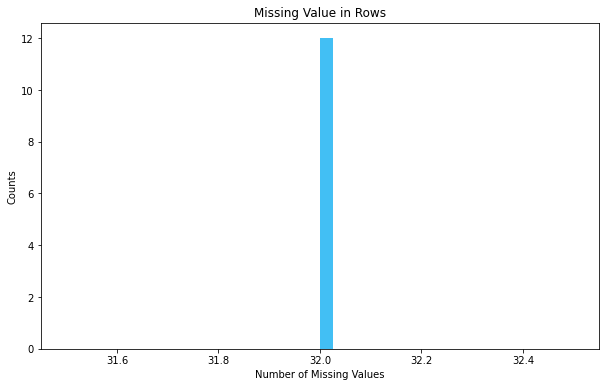

In [29]:
# Visualise
missing_r[missing_r > 0].plot(kind='hist', bins=40, figsize=(10,6), color=my_color[0])
plt.title('Missing Value in Rows')
plt.ylabel('Counts')
plt.xlabel('Number of Missing Values')
plt.show()

In [30]:
# Dropped the 12 rows with 32 missing values

for index in missing_r[missing_r > 0].index:
  df.drop(index, inplace = True)

In [37]:
df.shape

(590528, 50)

## Drop Transaction Date

In [35]:
df.drop('TransactionDT', axis=1, inplace = True)

## Clean 'Test' Data

In [38]:
# columns after data cleanning
cols = df.columns
cols = cols.drop('isFraud')

# drop unused columns
test = test[cols]
# shape (506691, 50)

## Save to csv

In [39]:
#df.to_csv('data/train.csv', index = False)
#test.to_csv('data/test.csv', index = False)

## Imbalanced Data

In [7]:
df = pd.read_csv('data/train.csv')

In [8]:
print(f"There are {df[df['isFraud']==1]['isFraud'].count()} \
({round(df[df['isFraud']==1]['isFraud'].count() / df.shape[0] *100,2)}%) \
Fraud Transactions and {df[df['isFraud']==0]['isFraud'].count()} \
Legitimate Transactions.")

There are 20661 (3.5%) Fraud Transactions and 569867 Legitimate Transactions.


In [9]:
# Split data into X and y

X = df.drop('isFraud', axis = 1)
y = df['isFraud']

In [10]:
Counter(y)

Counter({0: 569867, 1: 20661})

### Random Over Sampling

In [11]:
#from collections import Counter
#from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_sample(X, y)
sorted(Counter(y_ros).items())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0, 569867), (1, 569867)]

### Random Under Sampling

In [68]:
#from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_sample(X, y)
sorted(Counter(y_rus).items())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0, 20661), (1, 20661)]

### SMOTE

[SMOTENC](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTENC.html)

* Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTE-NC).

* Unlike `SMOTE`, `SMOTE-NC` for dataset containing **continuous** and **categorical** features.

In [77]:
from imblearn.over_sampling import SMOTENC

In [82]:
sm = SMOTENC(random_state=0, categorical_features=['ProductCD'])

In [ ]:
#X_sm, y_sm = sm().fit_resample(X, y)


## 对数转换

In [17]:
cols = df.columns.tolist()

In [19]:
# Log-transform the skewed features
skewed = cols.remove('ProductCD', 'isFraud')

TypeError: ignored

In [ ]:

features_log_transformed = pd.DataFrame(data = df)
features_log_transformed[skewed] = df[skewed].apply(lambda x: np.log(x + 1))

# Modeling - Supervised Learning